In [1]:
import uproot
import awkward
import uproot_methods
import numpy as np

from coffea import hist, processor
from coffea.hist import plot

import matplotlib.pyplot as plt
import mplhep as hep

In [2]:
pat = 'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2016/9_4_X_v04/QCD_Pt-800to1000_MuEnrichedPt5_TuneCUETP8M1_13TeV_pythia8_9_4_X_v04/'
fi = 'JetTree_mc_FatJets_Subjets_BoostedCommissioning_2.root'
f = uproot.open(pat+fi)

f["allEvents/hEventCount"].values[0]
#f['otree'].keys()



63192.0

In [3]:
def ja(df, counts, prefix, bnames):
    objp4 = awkward.JaggedArray.fromcounts(df[counts],
        uproot_methods.TLorentzVectorArray.from_ptetaphim(
            df[prefix + 'pt'].content,
            df[prefix + 'eta'].content,
            df[prefix + 'phi'].content,
            df[prefix + 'mass'].content if prefix + 'mass' in [br.decode('ASCII') for br in df.available] else df[prefix + 'pt'].zeros_like().content,
        )
    )
    branches = {k: df[prefix.split('.')[0]+'.'+v] for k,v in bnames.items()}
    obj = awkward.JaggedArray.zip(p4=objp4, **branches)
    obj['mass'] = obj['p4'].mass
    obj['pt'] = obj['p4'].pt
    obj['phi'] = obj['p4'].phi
    obj['eta'] = obj['p4'].eta
    return obj


In [4]:
class JetProcessor(processor.ProcessorABC):        
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Dataset")        
        pthat_axis = hist.Bin("pthat", r"$p_T$", 40,150,1200)
        
        axes = {
            'mass' : hist.Bin("mass", r"$m_{jet}$ [GeV]", 50, 0, 300),
            'pt' : hist.Bin("pt", r"$p_T$", 20,150,1200),
            'eta' : hist.Bin("eta", r"$\eta$", 20, -3,3),
            'flav' : hist.Bin("flav", r"flavour", [0,1,2,3,4,5,6]),
        }
        
        _hist_dict = {
            'pthat': hist.Hist("Counts", dataset_axis, pthat_axis),
            'mass': hist.Hist("Counts", dataset_axis, axes['mass'], axes['flav']),
            'mass_wcuts': hist.Hist("Counts", dataset_axis, axes['mass'], axes['flav']),
            
            'flav': hist.Hist("Counts", dataset_axis, axes['flav']),
            
        }   
        self._accumulator = processor.dict_accumulator(_hist_dict)
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        output['sumw'] = processor.dict_accumulator()
        
        dataset = df['dataset']    
        pthat = df['pthat']        
                                                
        subjets = ja(df, 'SoftDropPuppiSubJetInfo.nJet', 'SoftDropPuppiSubJetInfo.Jet_', 
                        {
                            'nsv':'Jet_SV_multi',
                        }
                    )

        muons = ja(df, 'SoftDropPuppiSubJetInfo.nPFMuon', 'SoftDropPuppiSubJetInfo.PFMuon_', 
                        {
                            'subjetIdx' : 'PFMuon_IdxJet',
                            
                            'isGlobal'  : 'PFMuon_isGlobal',                            
                        }
                    )
        
        jets = ja(df, 'FatJetInfo.nJet', 'FatJetInfo.Jet_', 
                        {
                            'nsj'   : 'Jet_nSubJets_SoftDropPuppi',
                            'firstsj' : 'Jet_nFirstSJ_SoftDropPuppi',

                            'doubleb':'Jet_DoubleSV',
                            'hflav' : 'Jet_flavour',
                            'bhad'  : 'Jet_nbHadrons',
                            'chad'  : 'Jet_ncHadrons',
                            'mass_prun' : 'Jet_massPruned',
                        }
                    )
        
        # Build subjets
        jnsj = df['FatJetInfo.Jet_nSubJets_SoftDropPuppi']
        sjidx = df['FatJetInfo.SubJetIdx_SoftDropPuppi']
        # build double-jagged index array
        subjetidx = awkward.JaggedArray.fromoffsets(jnsj.offsets, awkward.JaggedArray.fromcounts(jnsj.content, sjidx.content))
        # take advantage of broadcasting to turn into absolute index
        subjetidx = (subjetidx + subjets.starts).flatten().flatten()
        # use indexed array into actual subjet content
        jet_subjet_content = awkward.IndexedArray(subjetidx, subjets.content)
        # re-build double-jagged array now with content
        jet_subjet = awkward.JaggedArray.fromoffsets(jnsj.offsets, awkward.JaggedArray.fromcounts(jnsj.content, jet_subjet_content))
        jets['subjets'] = jet_subjet

        # Build muons
        # convert to absolute index
        muon_absjetidx = (muons['subjetIdx'] + subjets.starts).flatten()
        # use np.unique to get the number of muons associated with each subjet
        subjet_nmuons = np.zeros(subjets.content.size, dtype=subjets.offsets.dtype)
        subjets_wmuons, jet_muoncounts = np.unique(muon_absjetidx, return_counts=True)
        subjet_nmuons[subjets_wmuons] = jet_muoncounts
        # build the indexed table
        subjet_muons = awkward.JaggedArray.fromoffsets(subjets.offsets, awkward.JaggedArray.fromcounts(subjet_nmuons, muons.content))
        subjet_muons['dR'] =  subjet_muons['p4'].delta_r(subjets['p4'])
        subjets['muons'] = subjet_muons      
      
        # Cuts
        per_sj = ((jets['subjets']['nsv'] >=1).sum() >=2)
        per_mu = (((jets['subjets']['muons']['pt'] >=2 ).sum() >= 1).sum() >=2)
          
        # Define flavors
        _f_gbb = (abs(jets['hflav']) == 5) & (jets['bhad'] >= 2)
        _f_gcc = (abs(jets['hflav']) == 4) & (jets['bhad'] == 0) & (jets['chad'] >= 2)
        _f_b = (abs(jets['hflav']) == 5) & np.invert(_f_gbb)
        _f_c = (abs(jets['hflav']) == 4) & np.invert(_f_gcc)
        _f_l = (abs(jets['hflav']) < 4) | (abs(jets['hflav']) == 21)  #& (jets.bhad == 0) & (jets.chad == 0)
        _f = _f_l*1 + _f_c*2 + _f_b*3 + _f_gcc*4 + _f_gbb*5
        jets['flav'] = _f        
                
        output['pthat'].fill(dataset=dataset, pthat=pthat)
        output['flav'].fill(dataset=dataset, flav=jets['flav'].flatten())
        output['mass'].fill(dataset=dataset, mass=jets['mass'].flatten(), flav=jets['flav'].flatten())
        
        return output

    def postprocess(self, accumulator):
        return accumulator
    
    

In [5]:
json_dict = {'QCD_Pt-1000toInf_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228': ['root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04/QCD_Pt-1000toInf_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228/JetTree_mc_FatJets_Subjets_BoostedCommissioning_1.root',
  'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04/QCD_Pt-1000toInf_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228/JetTree_mc_FatJets_Subjets_BoostedCommissioning_10.root',
  'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04/QCD_Pt-1000toInf_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228/JetTree_mc_FatJets_Subjets_BoostedCommissioning_100.root',
  'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04/QCD_Pt-1000toInf_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228/JetTree_mc_FatJets_Subjets_BoostedCommissioning_101.root',
  'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04/QCD_Pt-1000toInf_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228/JetTree_mc_FatJets_Subjets_BoostedCommissioning_102.root',
  'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04/QCD_Pt-1000toInf_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228/JetTree_mc_FatJets_Subjets_BoostedCommissioning_103.root',
  'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04/QCD_Pt-1000toInf_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228/JetTree_mc_FatJets_Subjets_BoostedCommissioning_104.root',
  'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04/QCD_Pt-1000toInf_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228/JetTree_mc_FatJets_Subjets_BoostedCommissioning_105.root',
                                                                           ],
    'QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228': ['root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04/QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228/JetTree_mc_FatJets_Subjets_BoostedCommissioning_1.root',
  'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04/QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228/JetTree_mc_FatJets_Subjets_BoostedCommissioning_104.root',
  'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04/QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228/JetTree_mc_FatJets_Subjets_BoostedCommissioning_105.root',
  'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04/QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228/JetTree_mc_FatJets_Subjets_BoostedCommissioning_107.root',
  'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04/QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228/JetTree_mc_FatJets_Subjets_BoostedCommissioning_108.root',
                                                                        ]
}

from pprint import pprint
pprint(json_dict, depth=1)

{'QCD_Pt-1000toInf_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228': [...],
 'QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228': [...]}


In [6]:
import time
tstart = time.time()    

output = processor.run_uproot_job(json_dict,
                                  treename='btaganaFatJets/ttree',
                                  processor_instance=JetProcessor(),
                                  executor=processor.futures_executor,
                                  #executor=processor.iterative_executor,
                                  executor_args={'workers': 20, 'savemetrics': True},
                                  chunksize=500000,
                                 )

elapsed = time.time() - tstart
print(output)

Processing: 100%|██████████| 13/13 [00:25<00:00,  1.93s/items]

({'pthat': <Hist (dataset,pthat) instance at 0x2aaca3e0c668>, 'mass': <Hist (dataset,mass,flav) instance at 0x2aaca3de0470>, 'flav': <Hist (dataset,flav) instance at 0x2aaca3de0320>, 'sumw': {}}, {'bytesread': value_accumulator(int, 172556288), 'dataservers': set_accumulator({'p06636710y50388.cern.ch:1095', 'p06253947u35885.cern.ch:1095', 'p06636710d12165.cern.ch:1095', 'p06636710k42552.cern.ch:1095', 'p06636710j45805.cern.ch:1095', 'p06636710y63608.cern.ch:1095', 'p06636710t83205.cern.ch:1095', 'p06636710y67710.cern.ch:1095', 'p05614920c84527.cern.ch:1095', 'p06253937e38526.cern.ch:1095', 'p06253937k46044.cern.ch:1095', 'p06636710p77867.cern.ch:1095'}), 'columns': set_accumulator({'FatJetInfo.Jet_massPruned', 'FatJetInfo.Jet_flavour', 'FatJetInfo.Jet_nbHadrons', 'FatJetInfo.Jet_phi', 'SoftDropPuppiSubJetInfo.nPFMuon', 'FatJetInfo.Jet_ncHadrons', 'SoftDropPuppiSubJetInfo.Jet_eta', 'SoftDropPuppiSubJetInfo.Jet_SV_multi', 'FatJetInfo.Jet_eta', 'FatJetInfo.nJet', 'FatJetInfo.Jet_mass', 'S

In [7]:
histograms = output[0]

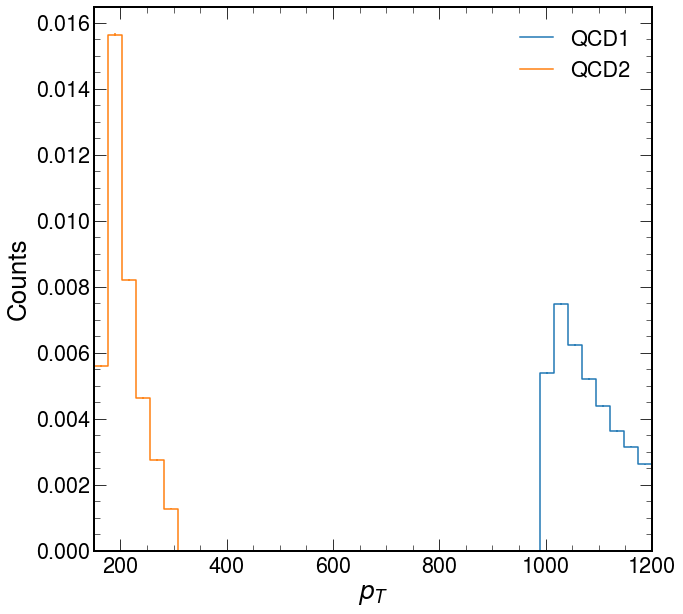

In [15]:
plt.style.use(hep.style.ROOT)
fig, ax, _ = plot.plot1d(histograms['pthat'], overlay='dataset', density=True)
ax.legend(["QCD1","QCD2"])

